## Import necessary modules
Dependencies:
 - numpy
 - pandas
 - matplotlib

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
sys.path.append("../src/")
from lbd_functions import plot_elevation,plot3sections,printtimelogwithstarline,printtimelog
from lbd_functions import gen_concatenated_lenses_params,gen_facies_youth_mx,get_facies_prop
from lbd_functions import Lense, get_model_dh_litho_thickness, get_model_litho_thickness
from utils import check_plot_2_sections, get_ecdf, interp_ecdf_normalize_x, get_ecdf_area_difference
from scipy.interpolate import RegularGridInterpolator

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import matplotlib.pyplot as plt

top_basement_fn = '../data/interfaces-sediment-basement/bot_base.npy'
top_weathered_basement_fn = '../data/interfaces-sediment-basement/bot_delt.npy'
top_deltaic_sediments_fn = '../data/interfaces-sediment-basement/top_delt.npy'

# bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv'
# ref_err_fn = '../data/boreholes-processed/LBW_extended_error-tolerance.pickle'
bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_corrected_summary.csv'
ref_err_fn = '../data/boreholes-processed/LBW_extended_corrected_error-tolerance.pickle'

# bo_output_json_fn = "../data/models-age-facies/bo-logs-step-1.json"
bo_output_json_fn = "../data/models-age-facies/bo-logs_corrected-step-1.json"

n_iter=3000 # 5000 # 100
plot=True
Verb=True

In [2]:
# DEFINE RANGE FOR PARAMETERS TO EXPLORE
intensity_sand = 8.0/100
truncation_sand = 22.5/100
length_sand = 4500
thickness_sand = 4.5

intensity_clay = 7.0/100
truncation_clay = 27.5/100
length_clay = 5000
thickness_clay = 3

# Bounded region of parameter space
pbounds = {'intensity_sand': (0.01, 0.30), 'truncation_sand': (0.1,0.3),
           'length_sand': (2000,9000), 'thickness_sand': (2.5,7.5),
           'intensity_clay': (0.01, 0.30), 'truncation_clay': (0.1,0.3),
           'length_clay': (3000,10000), 'thickness_clay': (1.5,5.5)
          }

In [3]:
# DEFINE FIXED PARAMETERS
intensity_tol = 5.0/100
truncation_tol = 7.5/100
length_tol = 50/100
thickness_tol = 40/100
truncationdist = 'uniform'
lengthdist = 'uniform'
thicknessdist = 'uniform'
anisotropy = 4
anisotropy_tol = 2
anisotropydist = 'uniform'
dipdir = 90*np.pi/180 # in radians
dipdir_tol = 10*np.pi/180 # in radians
dipdirdist = 'normal'
dip = 0
dip_tol = 0
dipdist = 'normal'
facies_sand = 2
facies_clay = 3

printtimelogwithstarline('DEFINE PARAMETERS')
lbdseed = 12345

printtimelog('model boundaries')
xmin=5.30E5
xmax=5.45E5
ymin=7.830E6
ymax=7.842E6
zmin=-80
zmax=20
dx=dy=250
dz=1

lithocodes = [-1,0,1,2,3]
labels = ["basement","weathered-basement","intermediate","sand","clay"]
lithocolors = ["pink","lavenderblush", "sienna", "gold", "grey"]
ndhsamples = 500 # to estimate thicknesses from generated models
rng = np.random.default_rng(lbdseed)

**********************************************************************
22-Feb-2025 (17:19:52) - DEFINE PARAMETERS
**********************************************************************
22-Feb-2025 (17:19:52) - model boundaries


In [4]:

# PROCESSING INPUT DATA
# AREA OF INTEREST GRID
aoi_nx = int((xmax-xmin)/dx)
aoi_ny = int((ymax-ymin)/dy)
aoi_nz = int((zmax-zmin)/dz)
aoi_vx = np.linspace(xmin+dx/2,xmax-dx/2,aoi_nx,endpoint=True)
aoi_vy = np.linspace(ymin+dy/2,ymax-dy/2,aoi_ny,endpoint=True)
aoi_vz = np.linspace(zmin+dz/2,zmax-dz/2,aoi_nz,endpoint=True)
aoi_xx,aoi_yy = np.meshgrid(aoi_vx,aoi_vy,indexing='xy')
aoi_pts = np.array([aoi_xx.flatten(),aoi_yy.flatten()]).T
# LOAD INTERFACES
top_basement =  np.load(top_basement_fn)
top_weathered_basement =  np.load(top_weathered_basement_fn)
top_deltaic_sediments =  np.load(top_deltaic_sediments_fn)
# GET INTERFACES DIMENSIONS
top_nx = len(np.unique(top_basement[:,0]))
top_ny = len(np.unique(top_basement[:,1]))
# GET INTERFACES X & Y COORDINATES
top_xx = np.flipud(np.reshape(top_basement[:,0],(top_ny,top_nx)))
top_yy = np.flipud(np.reshape(top_basement[:,1],(top_ny,top_nx)))
# RESHAPE INTERFACES AS 2D ARRAYS
zz_top_basement = np.flipud(np.reshape(top_basement[:,-1],(top_ny,top_nx)))
zz_top_weathered_basement = np.flipud(np.reshape(top_weathered_basement[:,-1],(top_ny,top_nx)))
zz_top_deltaic_sediments = np.flipud(np.reshape(top_deltaic_sediments[:,-1],(top_ny,top_nx)))
# ESTIMATE INTERFACES MASK
mask = zz_top_basement< zz_top_basement.max()
# APPLY MASK TO REMOVE MAX PLATEAU VALUES
zz_top_basement[mask==False]=np.nan
zz_top_weathered_basement[mask==False]=np.nan
zz_top_deltaic_sediments[mask==False]=np.nan
# ESTIMATE RESOLUTION
xc_min = top_basement[:,0].min()
xc_max = top_basement[:,0].max()
top_dx = (xc_max-xc_min)/(top_nx-1)
yc_min = top_basement[:,1].min()
yc_max = top_basement[:,1].max()
top_dy = (yc_max-yc_min)/(top_ny-1)
# INDEX OF INTERFACES IMAGES TO SELECT TO BUILD INTERPOLATOR
ix_select = (np.where(
    (top_xx >= xmin-top_dx) & (top_xx <= xmax+top_dx) &
    (top_yy >= ymin-top_dy) & (top_yy <= ymax+top_dy)
))
top_vx = np.sort(np.unique(top_xx[ix_select]))
top_vy = np.sort(np.unique(top_yy[ix_select]))
    
ori_top_basement = np.reshape(zz_top_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_weathered_basement = np.reshape(zz_top_weathered_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_deltaic_sediments = np.reshape(zz_top_deltaic_sediments[ix_select],(len(top_vy),len(top_vx)))

# DEFINE INTERPOLATORS
# # flip on y axis because of increasing vy
# data_tbt = np.flipud(ori_top_basement)
# data_twb = np.flipud(ori_top_weathered_basement)
# data_tds = np.flipud(ori_top_deltaic_sediments)

interp_top_basement = RegularGridInterpolator((top_vy, top_vx),ori_top_basement)
interp_top_weathered_basement = RegularGridInterpolator((top_vy, top_vx), ori_top_weathered_basement)
interp_top_deltaic_sediments = RegularGridInterpolator((top_vy, top_vx), ori_top_deltaic_sediments)

# INTERPOLATE INTERFACES
aoi_pts = np.array([aoi_yy.flatten(),aoi_xx.flatten()]).T    
aoi_top_basement = np.reshape(interp_top_basement(aoi_pts),(aoi_ny,aoi_nx))
aoi_top_weathered_basement = np.reshape(interp_top_weathered_basement(aoi_pts),(aoi_ny,aoi_nx))
aoi_top_deltaic_sediments = np.reshape(interp_top_deltaic_sediments(aoi_pts),(aoi_ny,aoi_nx))

# CREATE GRID
zzz,yyy,xxx = np.meshgrid(aoi_vz,aoi_vy,aoi_vx,indexing='ij')

# CREATE AQUIFER MASK
# 0 basement
# 1 aquifer domain
# np.nan above topography
tmp_twb = np.tile(np.reshape(aoi_top_weathered_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
tmp_tds = np.tile(np.reshape(aoi_top_deltaic_sediments,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
mask_aquifer = np.zeros((aoi_nz,aoi_ny,aoi_nx))
ix_aq = np.where((zzz>=tmp_twb)&(zzz<=tmp_tds))
mask_aquifer[ix_aq] = 1
ix_air = np.where(zzz>tmp_tds)
mask_aquifer[ix_air] = np.nan

printtimelog('load LBD 1-point statistics')
f = open(ref_err_fn, 'rb')
[prop_clay_mean_p5_p95, prop_sand_mean_p5_p95, prop_inte_mean_p5_p95,
 prop_clay_err_mean_p5_p95, prop_sand_err_mean_p5_p95, prop_inte_err_mean_p5_p95,
 ecdf_clay_mean_p5_p95, ecdf_sand_mean_p5_p95, ecdf_inte_mean_p5_p95, x01_vec, thickness_lim,
 ecdf_clay_area_err_mean_p5_p95, ecdf_sand_area_err_mean_p5_p95, ecdf_inte_area_err_mean_p5_p95] = pickle.load(f)
f.close()
nbins = len(x01_vec)-1
xlim = thickness_lim[1]


22-Feb-2025 (17:19:52) - load LBD 1-point statistics


In [5]:
# DEFINE BLACKBOX FUNCTION
# INPUT PARAMETERS
intensity_sand = 8.0/100
truncation_sand = 22.5/100
length_sand = 4500
thickness_sand = 4.5

intensity_clay = 7.0/100
truncation_clay = 27.5/100
length_clay = 5000
thickness_clay = 3

# OUTPUT: prox2lbd (1-dist2lbd)

def black_box_function(intensity_sand, truncation_sand, length_sand, thickness_sand, 
             intensity_clay, truncation_clay, length_clay, thickness_clay):
    intensity_sand_tol = intensity_tol * intensity_sand
    intensity_clay_tol = intensity_tol * intensity_clay
    length_sand_tol = length_tol * length_sand
    length_clay_tol = length_tol * length_clay
    thickness_sand_tol = thickness_tol *thickness_sand 
    thickness_clay_tol = thickness_tol *thickness_clay 
    # DEFINE LENSES CLASSES
    sandLenses = Lense(intensity_sand,intensity_sand_tol,
                     truncation_sand,truncation_tol,truncationdist,
                     length_sand,length_sand_tol,lengthdist,
                     thickness_sand,thickness_sand_tol,thicknessdist,
                     anisotropy,anisotropy_tol,anisotropydist,
                     dipdir,dipdir_tol,dipdirdist,
                     dip,dip_tol,dipdist,facies_sand)
    clayLenses = Lense(intensity_clay,intensity_clay_tol,
                     truncation_clay,truncation_tol,truncationdist,
                     length_clay,length_clay_tol,lengthdist,
                     thickness_clay,thickness_clay_tol,thicknessdist,
                     anisotropy,anisotropy_tol,anisotropydist,
                     dipdir,dipdir_tol,dipdirdist,
                     dip,dip_tol,dipdist,facies_clay)

    # GENERATE TRUNCATED ELLIPSOID PARAMS FOR SAND LENSES AND CLAY LENSES
    #printtimelog('generate lense params')
    lenseClassesList = [sandLenses,clayLenses]
    Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies = gen_concatenated_lenses_params(lenseClassesList,mask_aquifer,dx,dz,lbdseed+3)

    # GENERATE OBJECT BASED MODELS
    #printtimelog('generate object based model')
    facies_mx,relative_youth_mx = gen_facies_youth_mx(aoi_vx,aoi_vy,aoi_vz,Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies,mask_aquifer)

    # ADD DISTINCTION BETWEEN BASEMENT AND WEATHERED BASEMENT
    #printtimelog('differentiate basement from weathered basement')
    tmp_twt = np.tile(np.reshape(aoi_top_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
    ix_bst = np.where(zzz<tmp_twt)
    facies_mx[ix_bst]=-1
    
    # COMPUTE COUNT AND PROPORTIONS PER LITHOCODE
    #printtimelog('compute proportions')
    prop = get_facies_prop(facies_mx,mask_aquifer,lithocodes[2:],labels[2:])
    #print(prop)

    # GET THICKNESSES
    #printtimelog('extract thicknesses')
    df_model_thickness = get_model_litho_thickness(facies_mx,ndhsamples,aoi_nx,aoi_ny,lithocodes,zmin,dz,rng)

    # COMPUTE EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS OF THICKNESS PER LITHOCODE
    #printtimelogwithstarline('COMPUTE ECDFs')
    x_clay, ecdf_clay = get_ecdf(df_model_thickness,3)
    x_sand, ecdf_sand = get_ecdf(df_model_thickness,2)
    x_inte, ecdf_inte = get_ecdf(df_model_thickness,1)

    #printtimelog('normalize ecdfs')

    ecdf01_clay = interp_ecdf_normalize_x(x_clay,ecdf_clay,xlim,x01_vec)
    ecdf01_sand = interp_ecdf_normalize_x(x_sand,ecdf_sand,xlim,x01_vec)
    ecdf01_inte = interp_ecdf_normalize_x(x_inte,ecdf_inte,xlim,x01_vec)
    
    #printtimelogwithstarline('COMPUTE DISTANCE TO LBD DATASET')
    #printtimelog('compute errors')
    err_prop_clay = (float(prop.loc[3,'proportion'])/100-prop_clay_mean_p5_p95[0]) # / prop_clay_err_mean_p5_p95[0]
    err_prop_sand = (float(prop.loc[2,'proportion'])/100-prop_sand_mean_p5_p95[0]) #/ prop_sand_err_mean_p5_p95[0]
    
    err_ecfd_clay,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_clay_mean_p5_p95[:,0],x01_vec,ecdf01_clay,nbins=nbins) #/ ecdf_clay_area_err_mean_p5_p95[0]
    err_ecfd_sand,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_sand_mean_p5_p95[:,0],x01_vec,ecdf01_sand,nbins=nbins) #/ ecdf_sand_area_err_mean_p5_p95[0]
    # err_ratio_ecfd_inte,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_inte_mean_p5_p95[:,0],x01_vec,ecdf01_inte,nbins=nbins) #/ ecdf_inte_area_err_mean_p5_p95[0]

    #printtimelog('compute distance')
    errors = np.abs(np.array([err_prop_clay,err_prop_sand,err_ecfd_clay,err_ecfd_sand]))
    #print('errors: '+str(errors))

    dist2lbd = 1 - np.prod(1-errors)**(1/len(errors))
    #print('dist2lbd: '+str(dist2lbd))    
    return 1-dist2lbd

In [6]:
# Test function
black_box_function(intensity_sand, truncation_sand, length_sand, thickness_sand, 
         intensity_clay, truncation_clay, length_clay, thickness_clay)

0.9535222515776757

In [7]:
logger = JSONLogger(path=bo_output_json_fn)
acquisition_function = UtilityFunction(kind="ei", xi=1e-5)

bo = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2,
    random_state=12345,
)
bo.subscribe(Events.OPTIMIZATION_STEP, logger)

In [8]:
bo.maximize(init_points=4,n_iter=n_iter, acquisition_function=acquisition_function)

In [9]:
import json

nbo = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2,
    random_state=12345,
)
load_logs(nbo, logs=[bo_output_json_fn]);


In [10]:
tmp = nbo.res
# tmp

In [11]:
df = pd.DataFrame.from_dict(tmp)
df

,target,params
0,0.921330,"{'intensity_clay': 0.27958866691697287, 'inten..."
1,0.935068,"{'intensity_clay': 0.22718292488483444, 'inten..."
2,0.903981,"{'intensity_clay': 0.24484564023687108, 'inten..."
3,0.945441,"{'intensity_clay': 0.13749693570659474, 'inten..."
4,0.812231,"{'intensity_clay': 0.031121016900318182, 'inte..."
...,...,...
2999,0.806795,"{'intensity_clay': 0.28535882076304003, 'inten..."
3000,0.812802,"{'intensity_clay': 0.01745328443306752, 'inten..."
3001,0.958608,"{'intensity_clay': 0.16507430865804737, 'inten..."
3002,0.935816,"{'intensity_clay': 0.29866849542007556, 'inten..."


In [12]:
df.iloc[0,1]

{'intensity_clay': 0.27958866691697287,
 'intensity_sand': 0.1017489108287179,
 'length_clay': 4287.431681739661,
 'length_sand': 3431.9219498712782,
 'thickness_clay': 3.7709001163267466,
 'thickness_sand': 5.477723514896258,
 'truncation_clay': 0.2929029039471243,
 'truncation_sand': 0.23063541937431417}

In [13]:
df.iloc[0,1].keys()

dict_keys(['intensity_clay', 'intensity_sand', 'length_clay', 'length_sand', 'thickness_clay', 'thickness_sand', 'truncation_clay', 'truncation_sand'])

In [14]:
df.iloc[0,1].values()

dict_values([0.27958866691697287, 0.1017489108287179, 4287.431681739661, 3431.9219498712782, 3.7709001163267466, 5.477723514896258, 0.2929029039471243, 0.23063541937431417])

In [15]:
df.iloc[0,1].get('intensity_clay')

0.27958866691697287

([<matplotlib.lines.Line2D at 0x166017447f0>], (0.9, 1.0))

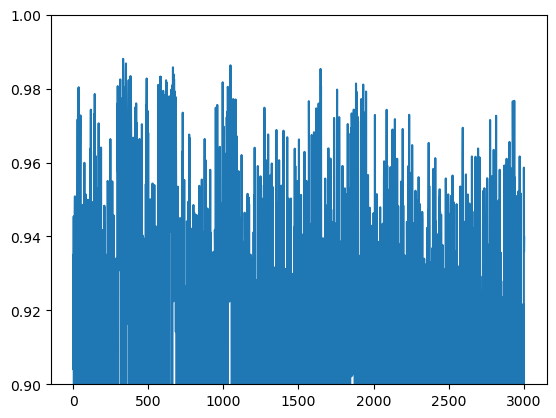

In [16]:
plt.plot(df['target']),plt.ylim([0.9,1])